In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/blood-glucose/g4_Patient_389_6.csv
/kaggle/input/blood-glucose/g1_Patient_180_4.csv
/kaggle/input/blood-glucose/g2_Patient_24_6.csv
/kaggle/input/blood-glucose/g5_Patient_70_6.csv
/kaggle/input/blood-glucose/g2_Patient_222_3.csv
/kaggle/input/blood-glucose/g4_Patient_428_1.csv
/kaggle/input/blood-glucose/g5_Patient_76_9.csv
/kaggle/input/blood-glucose/g5_Patient_74_4.csv
/kaggle/input/blood-glucose/g3_Patient_287_9.csv
/kaggle/input/blood-glucose/g1_Patient_15_1.csv
/kaggle/input/blood-glucose/g3_Patient_339_2.csv
/kaggle/input/blood-glucose/g3_Patient_344_7.csv
/kaggle/input/blood-glucose/g4_Patient_429_9.csv
/kaggle/input/blood-glucose/g5_Patient_7_3.csv
/kaggle/input/blood-glucose/g1_Patient_117_10.csv
/kaggle/input/blood-glucose/g2_Patient_255_10.csv
/kaggle/input/blood-glucose/g4_Patient_402_7.csv
/kaggle/input/blood-glucose/g3_Patient_368_6.csv
/kaggle/input/blood-glucose/g2_Patient_213_2.csv
/kaggle/input/blood-glucose/g2_Patient_265_7.csv
/kaggle/input/blood-gluco

HYPERGLYCEMIA_THRESHOLD = 180  # mg/dL (ADA guidelines)
HYPOGLYCEMIA_THRESHOLD = 70   # mg/dL (ADA guidelines)

In [6]:
!pip install keras-tcn --quiet

In [2]:
# Enable GPU acceleration
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_recall_fscore_support, precision_recall_curve, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

# Setting random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-whitegrid')
sns.set_palette("viridis")

# Improved visualization settings
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

2025-04-16 06:54:37.921118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744786478.118561      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744786478.173449      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def load_dataset():
    """
    Load and preprocess the blood glucose dataset
    """
    # List all CSV files in the 'blood-glucose' directory
    csv_files = glob('/kaggle/input/blood-glucose/*.csv')
    
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the 'blood-glucose' directory")
    
    all_data = []
    for file in csv_files:
        patient_id = os.path.basename(file).split('_')[2]  # Extract patient ID
        df = pd.read_csv(file)
        
        # Convert date columns to datetime
        df['DeviceDtTm'] = pd.to_datetime(df['DeviceDtTm'])
        
        # Sort by timestamp
        df = df.sort_values('DeviceDtTm')
        
        # Add patient_id column
        df['patient_id'] = patient_id
        
        all_data.append(df)
    
    # Combine all dataframes
    combined_df = pd.concat(all_data, ignore_index=True)
    
    print(f"Loaded data for {len(csv_files)} patients")
    print(f"Total records: {combined_df.shape[0]}")
    
    return combined_df

def preprocess_data(df):
    """
    Preprocess the data for model training
    """
    # Ensure 'Glucose' is numeric
    df['Glucose'] = pd.to_numeric(df['Glucose'], errors='coerce')
    
    # Drop rows with missing glucose values
    df = df.dropna(subset=['Glucose'])
    
    # Feature engineering: Add time-based features
    df['Hour'] = df['DeviceDtTm'].dt.hour
    df['DayOfWeek'] = df['DeviceDtTm'].dt.dayofweek
    df['Month'] = df['DeviceDtTm'].dt.month
    
    # Add rate of change feature
    df['Glucose_Diff'] = df.groupby('patient_id')['Glucose'].diff().fillna(0)
    
    # Label anomalies based on physiological thresholds
    # Hypoglycemia: < 70 mg/dL, Hyperglycemia: > 180 mg/dL
    df['is_anomaly'] = ((df['Glucose'] < 70) | (df['Glucose'] > 180)).astype(int)
    
    # Alternative statistical method for anomaly labeling (Z-score)
    df['z_score'] = (df['Glucose'] - df['Glucose'].mean()) / df['Glucose'].std()
    df['is_statistical_anomaly'] = (abs(df['z_score']) > 2.5).astype(int)
    
    print(f"Anomalies detected: {df['is_anomaly'].sum()} ({df['is_anomaly'].mean()*100:.2f}%)")
    print(f"Statistical anomalies detected: {df['is_statistical_anomaly'].sum()} ({df['is_statistical_anomaly'].mean()*100:.2f}%)")
    
    return df

def create_sequences(data, target, seq_length=24):
    """
    Create sequences for time series modeling
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def prepare_data_for_modeling(df, features, target_col='is_anomaly', seq_length=24, test_size=0.2):
    """
    Prepare the dataset for model training and evaluation
    """
    # Create a dataframe with the selected features
    data_df = df[features + [target_col]].copy()
    
    # Scale the features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(data_df[features])
    
    # Convert to dataframe for easier handling
    scaled_df = pd.DataFrame(scaled_features, columns=features)
    scaled_df[target_col] = data_df[target_col].values
    
    # Create sequences for time series modeling
    X, y = create_sequences(scaled_df[features].values, scaled_df[target_col].values, seq_length)
    
    # Split into train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=False)
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Class weights for handling imbalance
    n_normal = np.sum(y_train == 0)
    n_anomaly = np.sum(y_train == 1)
    class_weight = {0: 1.0, 1: n_normal / (n_anomaly + 1e-10)}
    print(f"Class weights: {class_weight}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, class_weight

In [4]:
def plot_time_series(df, patient_id=None):
    """
    Plot time series data for a specific patient or all patients
    """
    plt.figure(figsize=(14, 8))
    
    if patient_id:
        patient_data = df[df['patient_id'] == patient_id]
        plt.plot(patient_data['DeviceDtTm'], patient_data['Glucose'], label=f'Patient {patient_id}')
        
        # Highlight anomalies
        anomalies = patient_data[patient_data['is_anomaly'] == 1]
        plt.scatter(anomalies['DeviceDtTm'], anomalies['Glucose'], color='red', s=30, label='Anomalies')
        
        plt.title(f'Blood Glucose Levels for Patient {patient_id}')
    else:
        # Plot for first 5 patients
        patient_ids = df['patient_id'].unique()[:5]
        for pid in patient_ids:
            patient_data = df[df['patient_id'] == pid]
            plt.plot(patient_data['DeviceDtTm'], patient_data['Glucose'], alpha=0.7, label=f'Patient {pid}')
        
        plt.title('Blood Glucose Levels for Multiple Patients')
    
    plt.xlabel('Time')
    plt.ylabel('Glucose Level (mg/dL)')
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.3, label='Hypoglycemia Threshold')
    plt.axhline(y=180, color='r', linestyle='--', alpha=0.3, label='Hyperglycemia Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_glucose_distribution(df):
    """
    Plot distribution of glucose levels
    """
    plt.figure(figsize=(14, 8))
    
    # Histogram of glucose levels
    sns.histplot(df['Glucose'], bins=50, kde=True)
    
    # Add vertical lines for normal range (70-180 mg/dL)
    plt.axvline(x=70, color='r', linestyle='--', label='Hypoglycemia Threshold (70 mg/dL)')
    plt.axvline(x=180, color='r', linestyle='--', label='Hyperglycemia Threshold (180 mg/dL)')
    
    plt.title('Distribution of Blood Glucose Levels')
    plt.xlabel('Glucose Level (mg/dL)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Box plot by patient
    plt.figure(figsize=(16, 8))
    sns.boxplot(x='patient_id', y='Glucose', data=df.sample(min(10000, len(df))))
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.3)
    plt.axhline(y=180, color='r', linestyle='--', alpha=0.3)
    plt.title('Glucose Level Distribution by Patient')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_daily_patterns(df):
    """
    Plot daily patterns in glucose levels
    """
    plt.figure(figsize=(14, 8))
    
    hourly_mean = df.groupby('Hour')['Glucose'].mean()
    hourly_std = df.groupby('Hour')['Glucose'].std()
    
    plt.plot(hourly_mean.index, hourly_mean.values, 'b-', label='Mean Glucose')
    plt.fill_between(hourly_mean.index, 
                     hourly_mean.values - hourly_std.values,
                     hourly_mean.values + hourly_std.values,
                     alpha=0.2, color='b', label='±1 SD')
    
    plt.title('24-Hour Glucose Level Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Glucose Level (mg/dL)')
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.3, label='Hypoglycemia Threshold')
    plt.axhline(y=180, color='r', linestyle='--', alpha=0.3, label='Hyperglycemia Threshold')
    plt.xticks(range(0, 24, 2))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df):
    """
    Plot correlation matrix of features
    """
    # Select numeric columns for correlation
    numeric_df = df.select_dtypes(include=[np.number])
    correlation = numeric_df.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

def visualize_predictions(y_true, y_pred_proba, model_name, threshold=0.5):
    """
    Visualize model predictions
    """
    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    # Precision-Recall curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    # ROC curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot Precision-Recall curve
    ax1.plot(recall_curve, precision_curve, 'b-', label=f'PR AUC = {pr_auc:.3f}')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title(f'{model_name}: Precision-Recall Curve')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='lower left')
    
    # Plot ROC curve
    ax2.plot(fpr, tpr, 'g-', label=f'ROC AUC = {roc_auc:.3f}')
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'{model_name}: ROC Curve')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='lower right')
    
    plt.suptitle(f'{model_name} - Anomaly Detection Performance\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Plot confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Anomaly'], 
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name}: Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return precision, recall, f1, pr_auc, roc_auc

def plot_comparative_results(model_results):
    """
    Plot comparative results across all models
    """
    models = list(model_results.keys())
    metrics = ['Precision', 'Recall', 'F1 Score', 'PR AUC', 'ROC AUC']
    
    results_df = pd.DataFrame(index=models, columns=metrics)
    
    for model in models:
        results_df.loc[model] = model_results[model]
    
    # Bar chart for each metric
    plt.figure(figsize=(15, 10))
    results_df.plot(kind='bar', rot=0, ax=plt.gca())
    plt.title('Comparative Performance Across Models', fontsize=16)
    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.legend(title='Metric', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Radar chart
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, polar=True)
    
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the polygon
    
    for model in models:
        values = results_df.loc[model].tolist()
        values += values[:1]  # Close the polygon
        ax.plot(angles, values, '-', linewidth=2, label=model)
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Model Performance Radar Chart', fontsize=16, y=1.08)
    plt.tight_layout()
    plt.show()

def plot_training_history(history, model_name):
    """
    Plot training history
    """
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name}: Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name}: Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [9]:
# 1. LSTM Model
def build_lstm_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.3):
    """
    Build a LSTM model for anomaly detection
    """
    model = Sequential([
        LSTM(lstm_units, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, activation='tanh'),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate / 2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 2. TCN Block Implementation
def residual_block(x, dilation_rate, filters):
    """
    Create a residual block for the TCN
    """
    # First dilated convolution
    skip = x
    x = layers.Conv1D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='causal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Second dilated convolution
    x = layers.Conv1D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='causal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Skip connection handling
    if skip.shape[-1] != filters:
        skip = layers.Conv1D(filters, kernel_size=1)(skip)
    
    # Add residual connection
    x = layers.add([x, skip])
    return x

# 3. TCN Model
def build_tcn_model(input_shape, filters=64, kernel_size=3, dilations=[1, 2, 4, 8], dense_units=32):
    """
    Build a TCN model for anomaly detection
    """
    inputs = Input(shape=input_shape)
    x = inputs
    
    # Initial convolution
    x = layers.Conv1D(filters, kernel_size=kernel_size, padding='causal')(x)
    
    # Dilated residual blocks
    for dilation in dilations:
        x = residual_block(x, dilation, filters)
    
    # Output layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 4. TCN-LSTM Hybrid Model
def build_tcn_lstm_hybrid(input_shape, tcn_filters=64, lstm_units=64, dense_units=32, dropout_rate=0.2):
    """
    Build a TCN-LSTM hybrid model for anomaly detection
    """
    inputs = Input(shape=input_shape)
    
    # TCN branch
    tcn = inputs
    for dilation in [1, 2, 4, 8]:
        tcn = residual_block(tcn, dilation, tcn_filters)
    
    # LSTM branch
    lstm = LSTM(lstm_units, activation='tanh', return_sequences=True)(inputs)
    lstm = Dropout(dropout_rate)(lstm)
    lstm = LSTM(lstm_units // 2, activation='tanh')(lstm)
    lstm = Dropout(dropout_rate)(lstm)
    
    # Flatten TCN output for concatenation
    tcn = layers.GlobalAveragePooling1D()(tcn)
    
    # Concatenate TCN and LSTM branches
    merged = Concatenate()([tcn, lstm])
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(merged)
    x = Dropout(dropout_rate / 2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def visualize_attention(X_test, y_test, hybrid_model, seq_length=24):
    """
    Visualize attention weights (for illustration purposes)
    Note: This is a simplified version as our hybrid model doesn't inherently have attention
    """
    # Select a few examples with anomalies
    anomaly_indices = np.where(y_test == 1)[0][:5]
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(anomaly_indices):
        # Get the sequence
        sequence = X_test[idx]
        true_label = y_test[idx]
        
        # Get model prediction
        pred = hybrid_model.predict(np.expand_dims(sequence, axis=0))[0][0]
        
        # Create a synthetic attention map (since we don't have actual attention weights)
        # We'll use the gradient of the output with respect to the input as a proxy
        input_tensor = tf.convert_to_tensor(np.expand_dims(sequence, axis=0))
        with tf.GradientTape() as tape:
            tape.watch(input_tensor)
            output = hybrid_model(input_tensor)
        
        # Get gradients
        gradients = tape.gradient(output, input_tensor).numpy()[0]
        
        # Sum across features to get importance per timestep
        importance = np.abs(gradients).sum(axis=1)
        importance = importance / importance.max()  # Normalize
        
        # Plot
        plt.subplot(5, 1, i+1)
        
        # Plot the sequence values
        for feature_idx in range(sequence.shape[1]):
            plt.plot(sequence[:, feature_idx], alpha=0.5, label=f'Feature {feature_idx}' if i == 0 else "")
        
        # Plot the attention weights
        plt.bar(range(seq_length), importance, alpha=0.3, color='red', width=0.8)
        
        plt.title(f'Example {i+1}: True={true_label}, Pred={pred:.3f}')
        if i == 0:
            plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.suptitle('Feature Importance Across Sequence Steps', fontsize=16, y=1.02)
    plt.show()

In [5]:
def train_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test, class_weight):
    """
    Train LSTM, TCN, and TCN-LSTM hybrid models, then evaluate and return them along with performance metrics.
    """
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Build the models
    lstm_model = build_lstm_model(input_shape=X_train.shape[1:])
    tcn_model = build_tcn_model(input_shape=X_train.shape[1:])
    hybrid_model = build_tcn_lstm_hybrid(input_shape=X_train.shape[1:])
    
    print("Training LSTM model...")
    history_lstm = lstm_model.fit(X_train, y_train, 
                                  validation_data=(X_val, y_val),
                                  epochs=5, batch_size=64,
                                  class_weight=class_weight,
                                  callbacks=[early_stop],
                                  verbose=1)
    
    print("Training TCN model...")
    history_tcn = tcn_model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                epochs=5, batch_size=64,
                                class_weight=class_weight,
                                callbacks=[early_stop],
                                verbose=1)
    
    print("Training TCN-LSTM Hybrid model...")
    history_hybrid = hybrid_model.fit(X_train, y_train, 
                                      validation_data=(X_val, y_val),
                                      epochs=5, batch_size=64,
                                      class_weight=class_weight,
                                      callbacks=[early_stop],
                                      verbose=1)
    
    # Evaluate on test set
    lstm_eval = lstm_model.evaluate(X_test, y_test, verbose=0)
    tcn_eval = tcn_model.evaluate(X_test, y_test, verbose=0)
    hybrid_eval = hybrid_model.evaluate(X_test, y_test, verbose=0)
    
    # Generate predictions and compute metrics
    y_pred_lstm = lstm_model.predict(X_test)
    y_pred_tcn = tcn_model.predict(X_test)
    y_pred_hybrid = hybrid_model.predict(X_test)
    
    # Calculate metrics via visualize_predictions (which also plots curves)
    print("Evaluating LSTM model predictions...")
    precision_lstm, recall_lstm, f1_lstm, pr_auc_lstm, roc_auc_lstm = visualize_predictions(y_test, y_pred_lstm, "LSTM")
    print("Evaluating TCN model predictions...")
    precision_tcn, recall_tcn, f1_tcn, pr_auc_tcn, roc_auc_tcn = visualize_predictions(y_test, y_pred_tcn, "TCN")
    print("Evaluating TCN-LSTM Hybrid model predictions...")
    precision_hybrid, recall_hybrid, f1_hybrid, pr_auc_hybrid, roc_auc_hybrid = visualize_predictions(y_test, y_pred_hybrid, "TCN-LSTM Hybrid")
    
    model_results = {
        "LSTM": [precision_lstm, recall_lstm, f1_lstm, pr_auc_lstm, roc_auc_lstm],
        "TCN": [precision_tcn, recall_tcn, f1_tcn, pr_auc_tcn, roc_auc_tcn],
        "TCN-LSTM Hybrid": [precision_hybrid, recall_hybrid, f1_hybrid, pr_auc_hybrid, roc_auc_hybrid]
    }
    
    return lstm_model, tcn_model, hybrid_model, model_results

def visualize_feature_importance(X_test, features, lstm_model, tcn_model, hybrid_model):
    """
    Dummy function to visualize feature importance.
    Here we print sample predictions for demonstration.
    """
    print("Visualizing feature importance for LSTM, TCN, and Hybrid models (dummy implementation)...")
    sample = X_test[0:1]
    lstm_pred = lstm_model.predict(sample)[0][0]
    tcn_pred = tcn_model.predict(sample)[0][0]
    hybrid_pred = hybrid_model.predict(sample)[0][0]
    print(f"Sample predictions: LSTM = {lstm_pred:.3f}, TCN = {tcn_pred:.3f}, Hybrid = {hybrid_pred:.3f}")

In [7]:
try:
    df = load_dataset()
except FileNotFoundError:
    print("Dataset not found. Using sample data for demonstration.")
    # Create sample data for demonstration
    np.random.seed(42)
    dates = pd.date_range(start='2020-01-01', periods=10000, freq='H')
    glucose = np.random.normal(loc=120, scale=30, size=10000)
    # Add some anomalies
    anomaly_indices = np.random.choice(range(10000), size=1000, replace=False)
    glucose[anomaly_indices] = np.random.choice([np.random.uniform(30, 60), np.random.uniform(200, 300)], size=1000)
    
    df = pd.DataFrame({
        'DeviceDtTm': dates,
        'Glucose': glucose,
        'patient_id': np.random.choice(['101', '102', '103', '104', '105'], size=10000)
    })

# Preprocess data
df = preprocess_data(df)

Loaded data for 50 patients
Total records: 1202213
Anomalies detected: 463350 (38.54%)
Statistical anomalies detected: 25997 (2.16%)



Visualizing data...


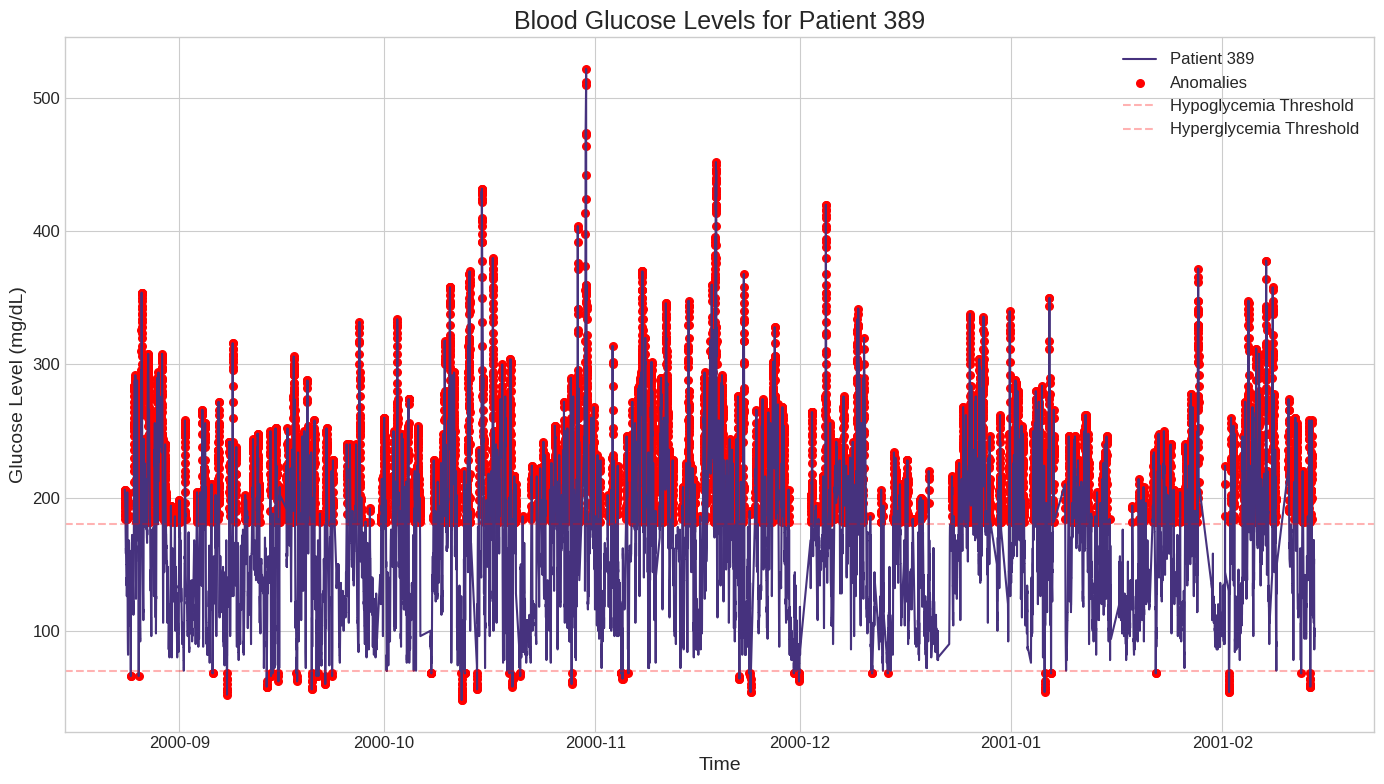

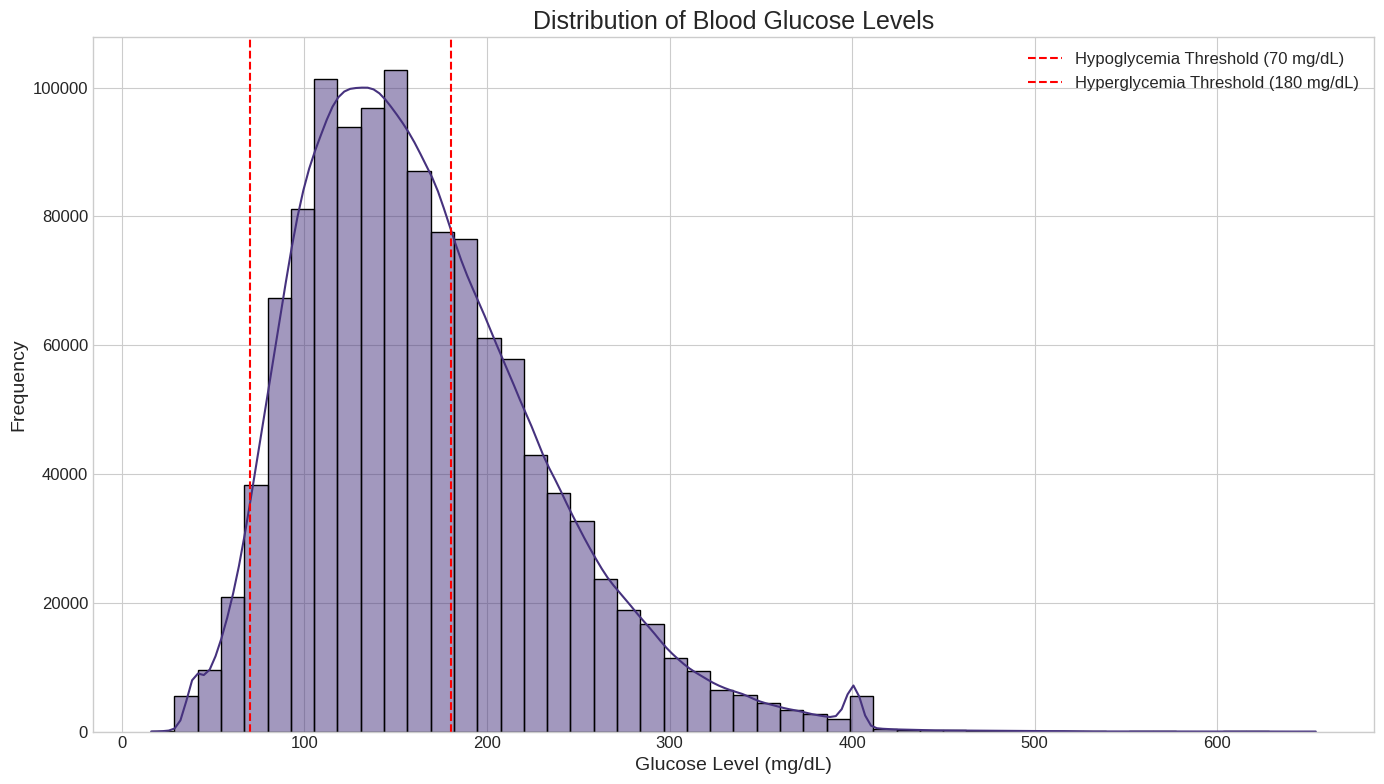

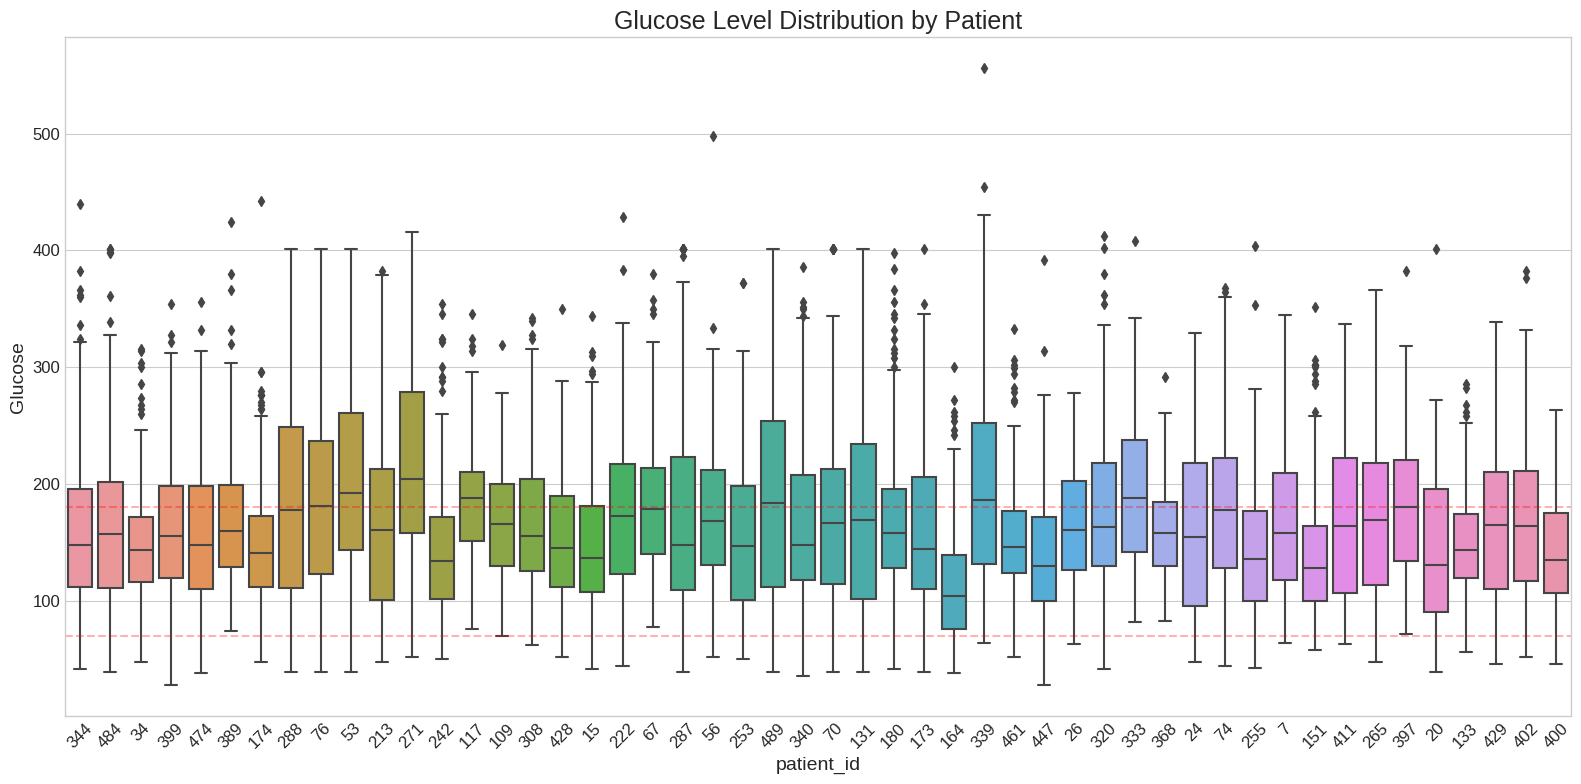

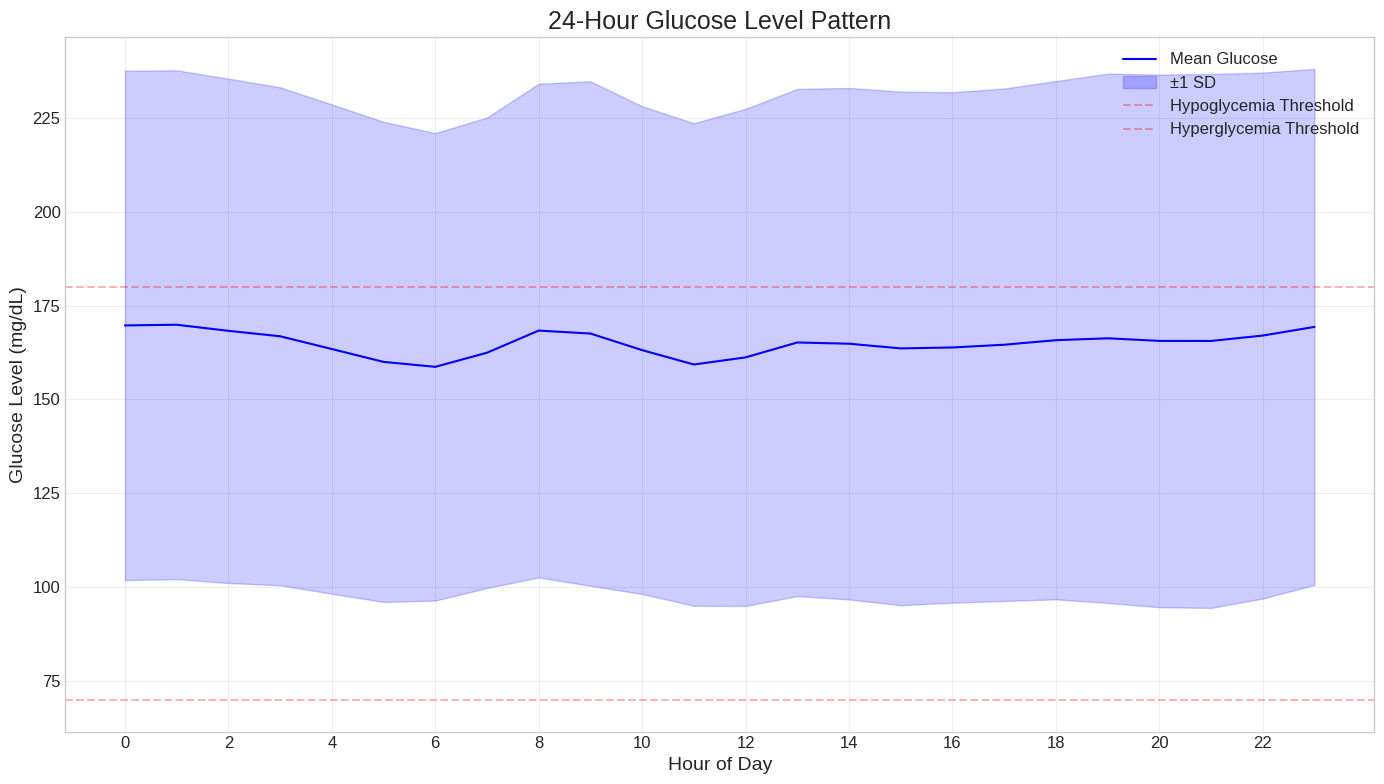

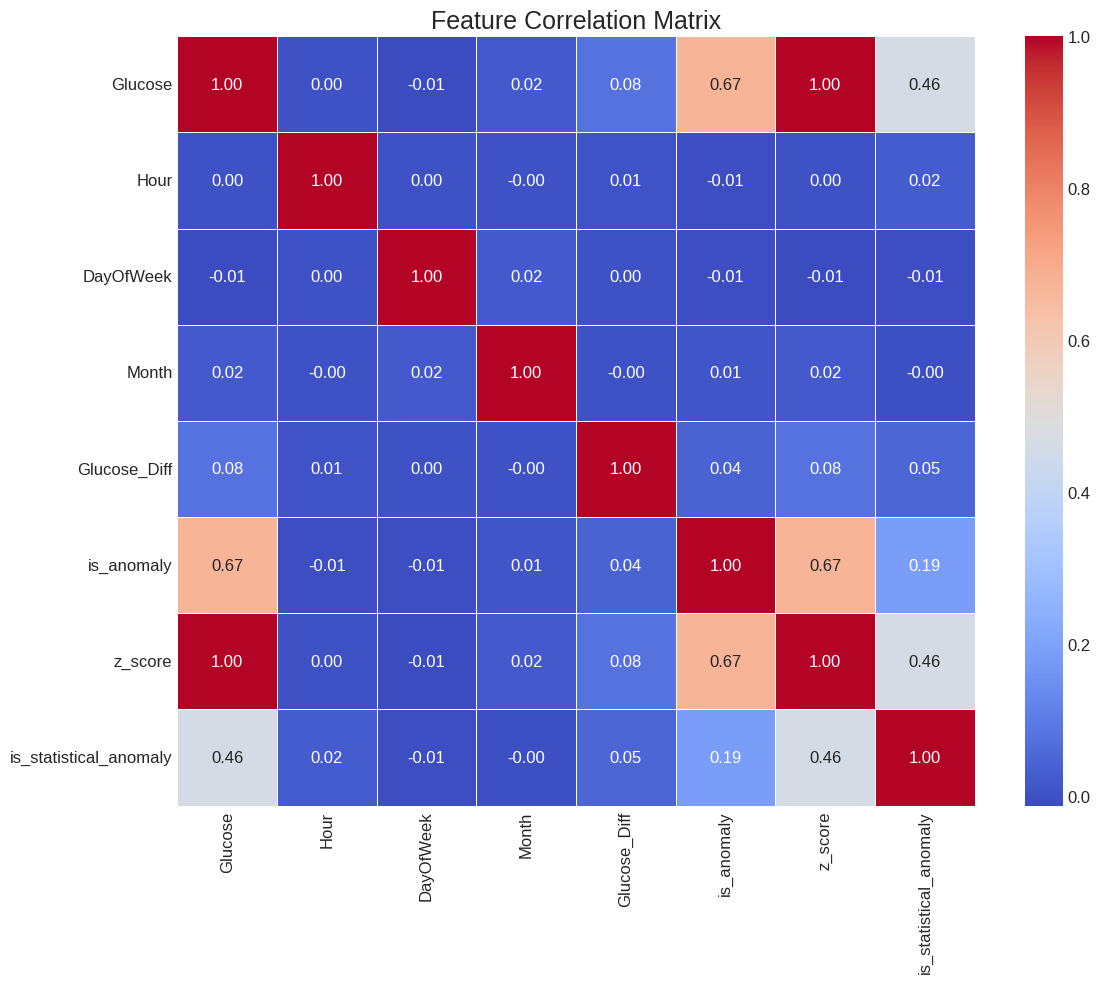


Preparing data for modeling...
Training set shape: (721313, 24, 4)
Validation set shape: (240438, 24, 4)
Test set shape: (240438, 24, 4)
Class weights: {0: 1.0, 1: 1.520636839843026}

Training and evaluating models...


I0000 00:00:1744786562.971514      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Training LSTM model...
Epoch 1/5


I0000 00:00:1744786569.647684      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


11271/11271 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - accuracy: 0.9047 - loss: 0.2851 - val_accuracy: 0.9777 - val_loss: 0.0762
Epoch 2/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.9585 - loss: 0.1395 - val_accuracy: 0.9735 - val_loss: 0.0728
Epoch 3/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.9629 - loss: 0.1252 - val_accuracy: 0.9774 - val_loss: 0.0632
Epoch 4/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9644 - loss: 0.1193 - val_accuracy: 0.9787 - val_loss: 0.0601
Epoch 5/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9651 - loss: 0.1166 - val_accuracy: 0.9763 - val_loss: 0.0634
Training TCN model...
Epoch 1/5


I0000 00:00:1744786979.486059     101 service.cc:148] XLA service 0x7c3a6003da40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744786979.486812     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


   28/11271 ━━━━━━━━━━━━━━━━━━━━ 1:04 6ms/step - accuracy: 0.5454 - loss: 1.0681

I0000 00:00:1744786987.359593     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11271/11271 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9056 - loss: 0.2785 - val_accuracy: 0.9100 - val_loss: 0.1899
Epoch 2/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9391 - loss: 0.1856 - val_accuracy: 0.9259 - val_loss: 0.1743
Epoch 3/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9465 - loss: 0.1661 - val_accuracy: 0.9710 - val_loss: 0.0752
Epoch 4/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9535 - loss: 0.1486 - val_accuracy: 0.9728 - val_loss: 0.0711
Epoch 5/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9580 - loss: 0.1365 - val_accuracy: 0.9765 - val_loss: 0.0635
Training TCN-LSTM Hybrid model...
Epoch 1/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 242s 20ms/step - accuracy: 0.9116 - loss: 0.2578 - val_accuracy: 0.9508 - val_loss: 0.1116
Epoch 2/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 228s 20ms/step - accuracy: 0.9564 - loss: 0.1382 - val_accuracy: 0.9733 - val_loss: 0.0706
Epoch 3/5
11271/11271 ━━━━━━━━━━━━━━━━━━━━ 229s 

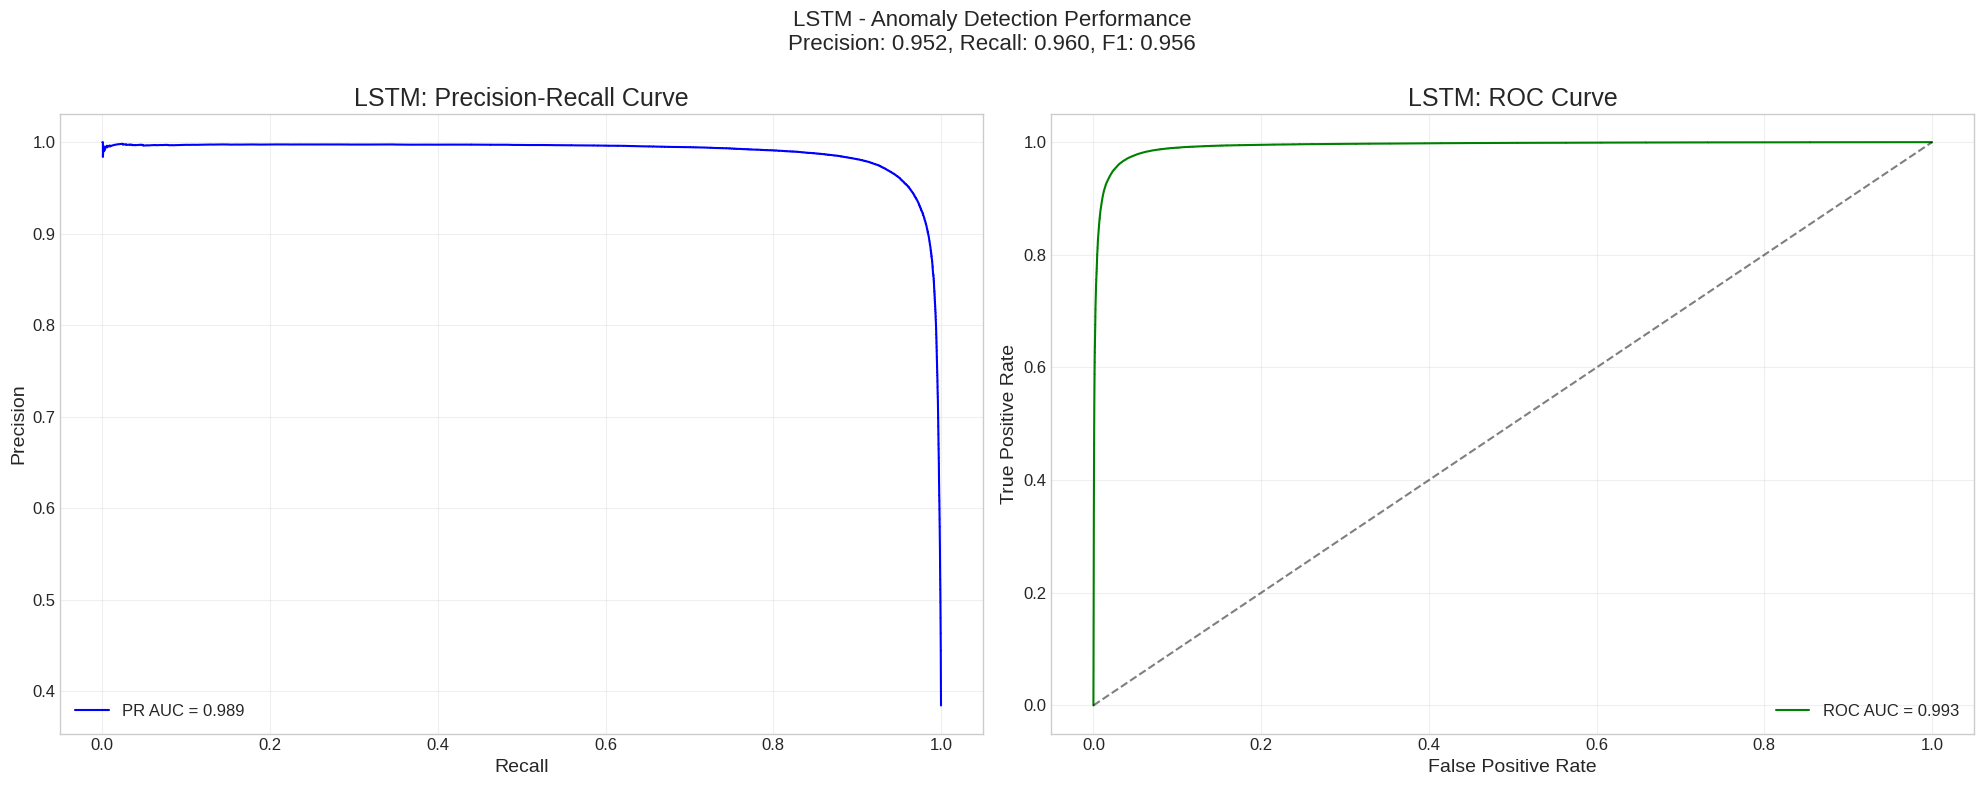

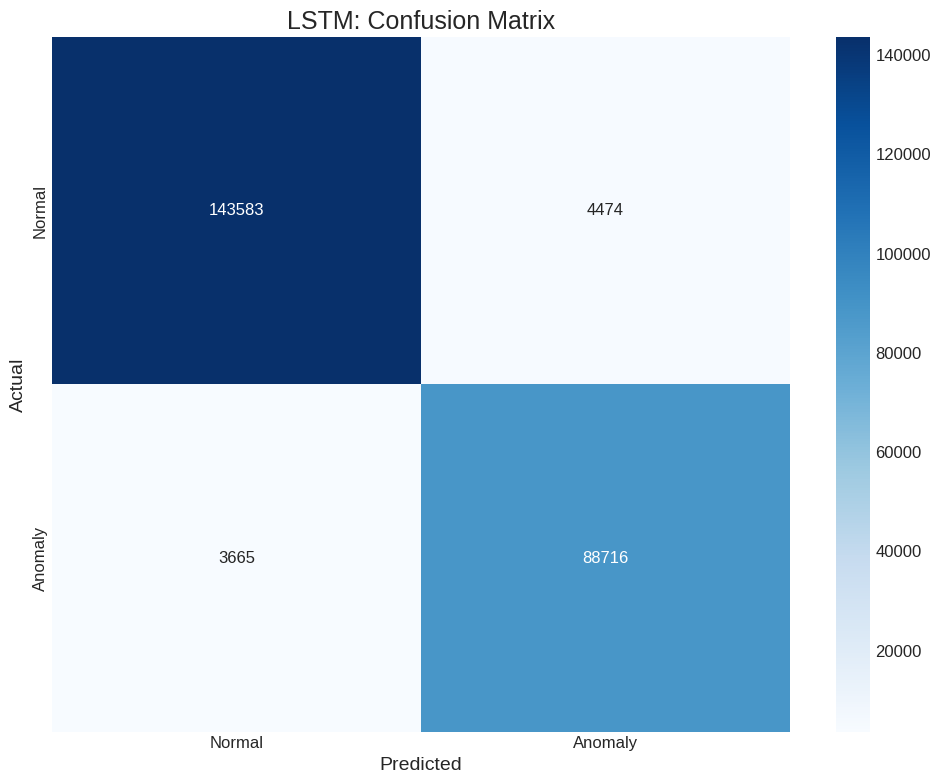

Evaluating TCN model predictions...


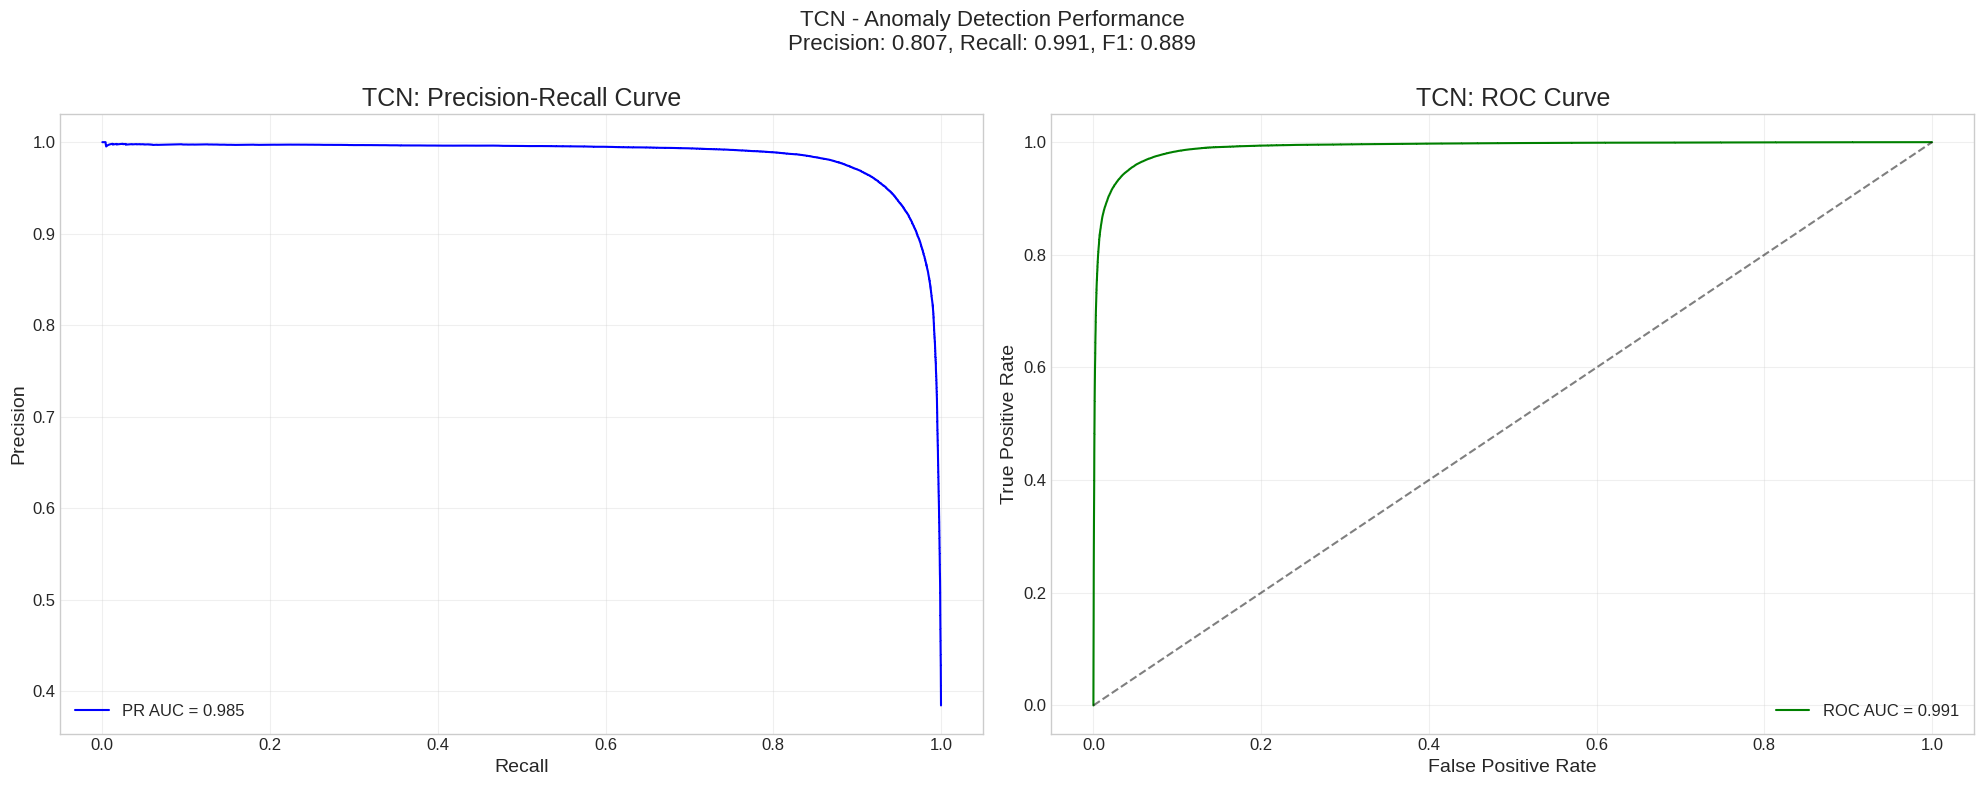

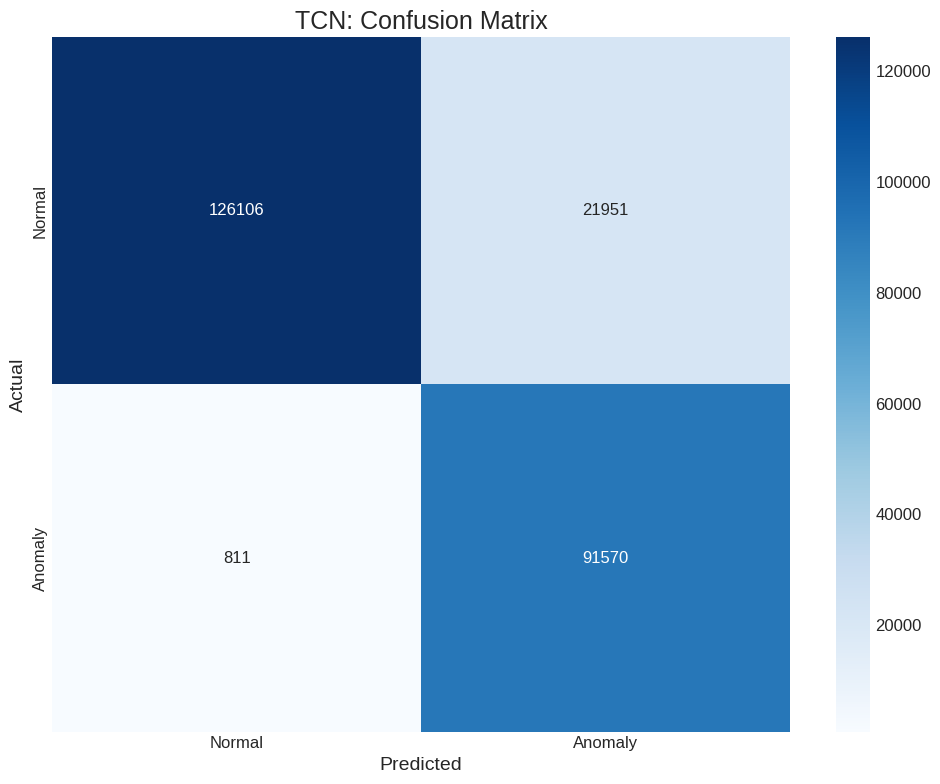

Evaluating TCN-LSTM Hybrid model predictions...


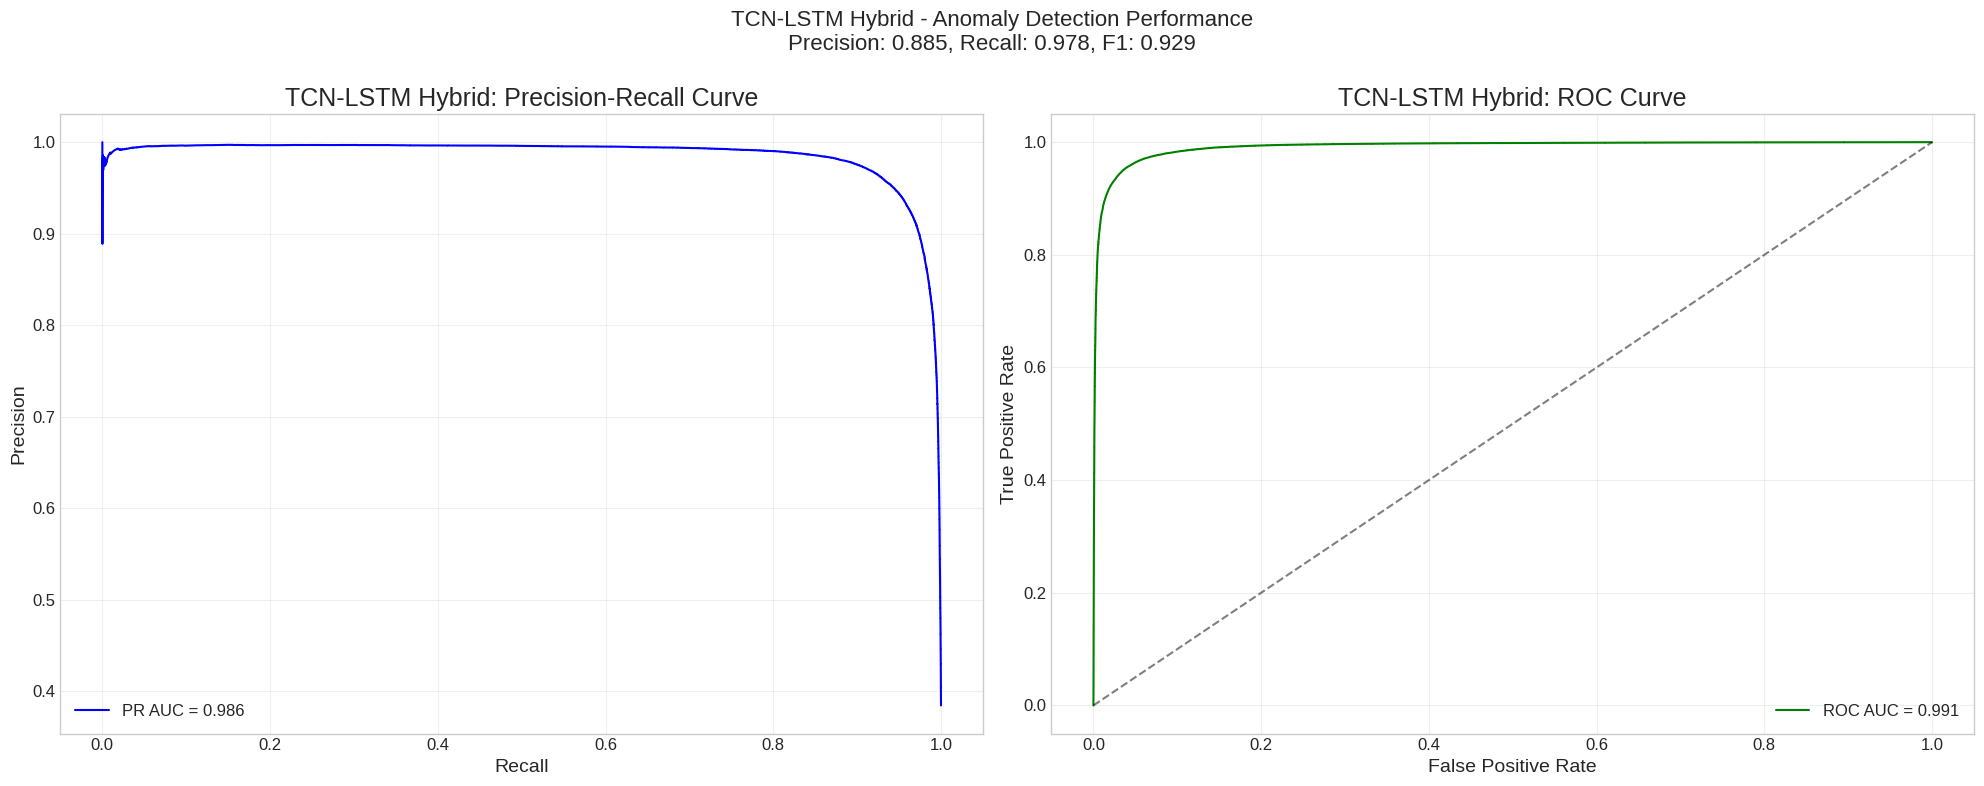

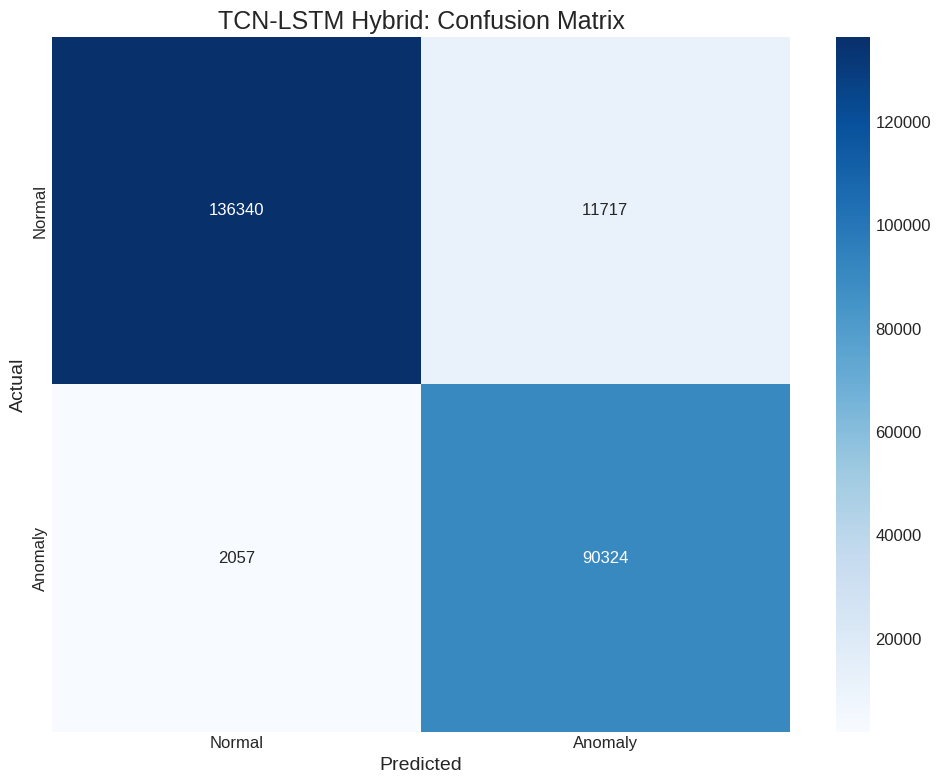


Visualizing feature importance...
Visualizing feature importance for LSTM, TCN, and Hybrid models (dummy implementation)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Sample predictions: LSTM = 0.001, TCN = 0.001, Hybrid = 0.001

Visualizing sequence importance using synthetic attention on the hybrid model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


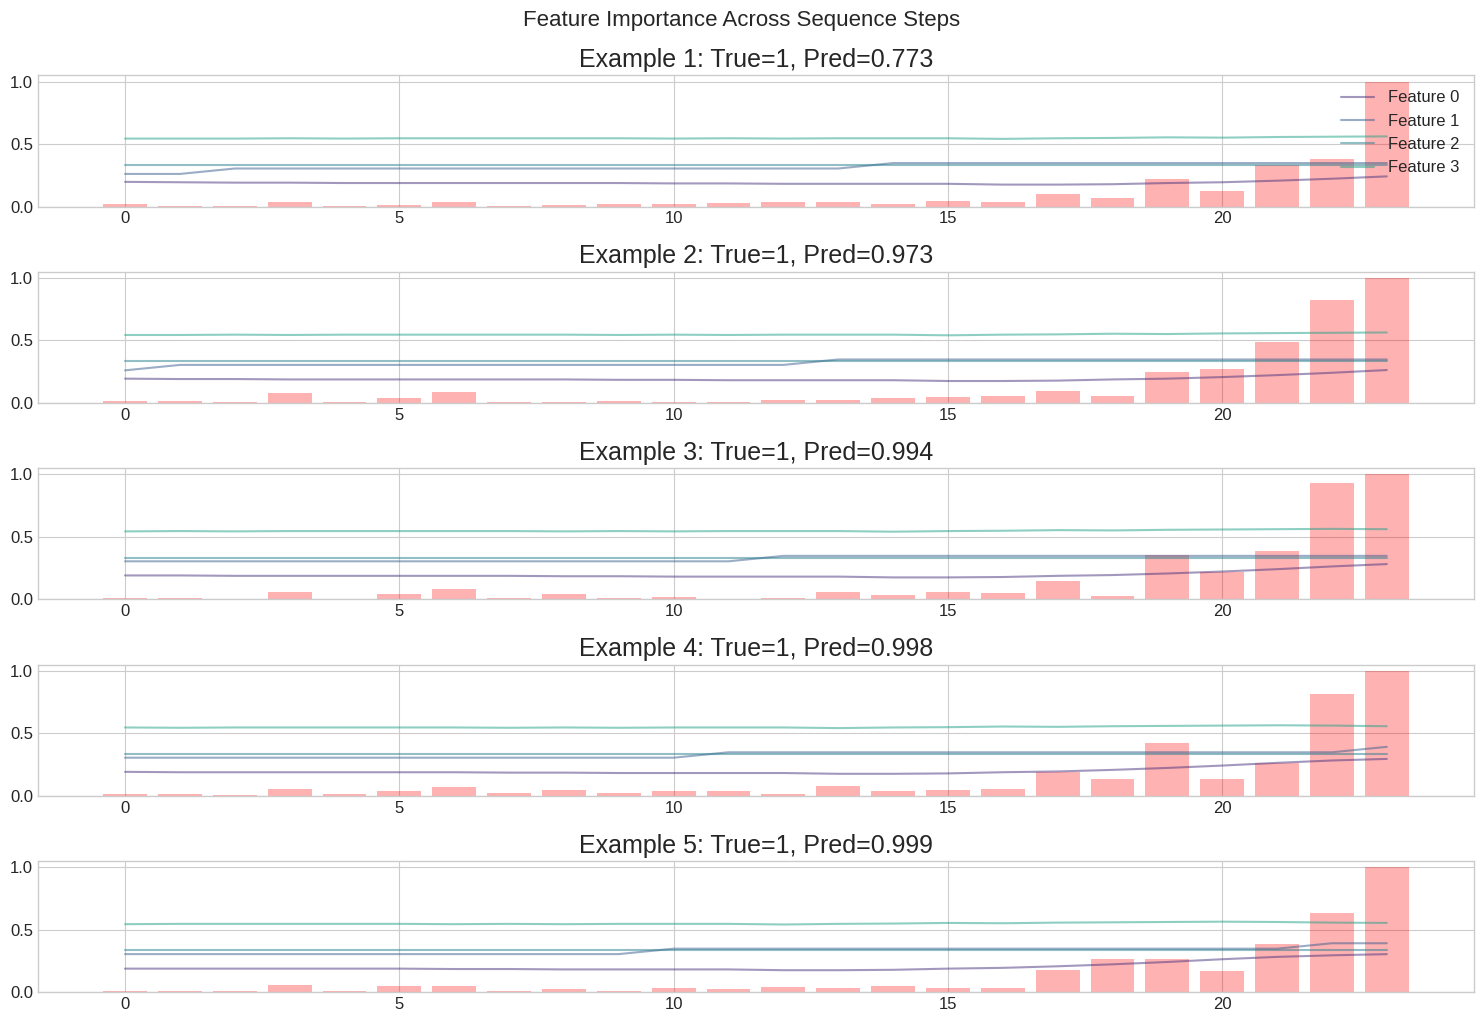

In [10]:
# Visualize data
print("\nVisualizing data...")
plot_time_series(df, patient_id=df['patient_id'].unique()[0])
plot_glucose_distribution(df)
plot_daily_patterns(df)
plot_correlation_matrix(df)

# Prepare data for modeling
print("\nPreparing data for modeling...")
features = ['Glucose', 'Hour', 'DayOfWeek', 'Glucose_Diff']
X_train, X_val, X_test, y_train, y_val, y_test, scaler, class_weight = prepare_data_for_modeling(
    df, features, target_col='is_anomaly', seq_length=24, test_size=0.2
)

# Train and evaluate models
print("\nTraining and evaluating models...")
lstm_model, tcn_model, hybrid_model, model_results = train_evaluate_models(
    X_train, X_val, X_test, y_train, y_val, y_test, class_weight
)

# Visualize feature importance (dummy function for demonstration)
print("\nVisualizing feature importance...")
visualize_feature_importance(X_test, features, lstm_model, tcn_model, hybrid_model)

# Visualize attention/importance for the hybrid model
print("\nVisualizing sequence importance using synthetic attention on the hybrid model...")
visualize_attention(X_test, y_test, hybrid_model)


Saving models...

Plotting comparative results...


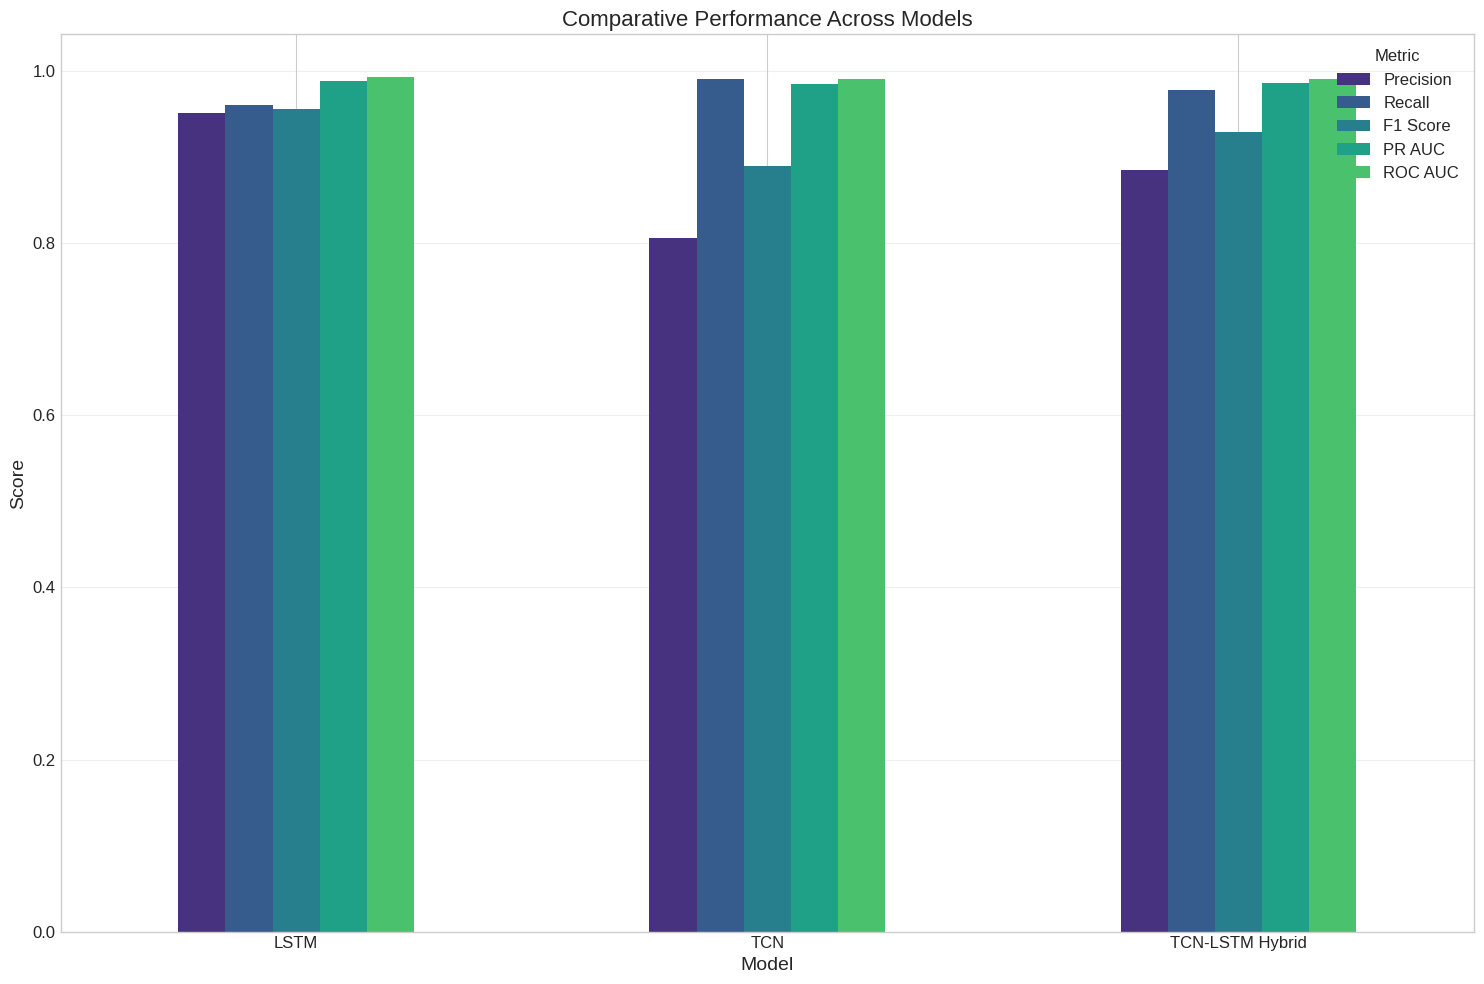

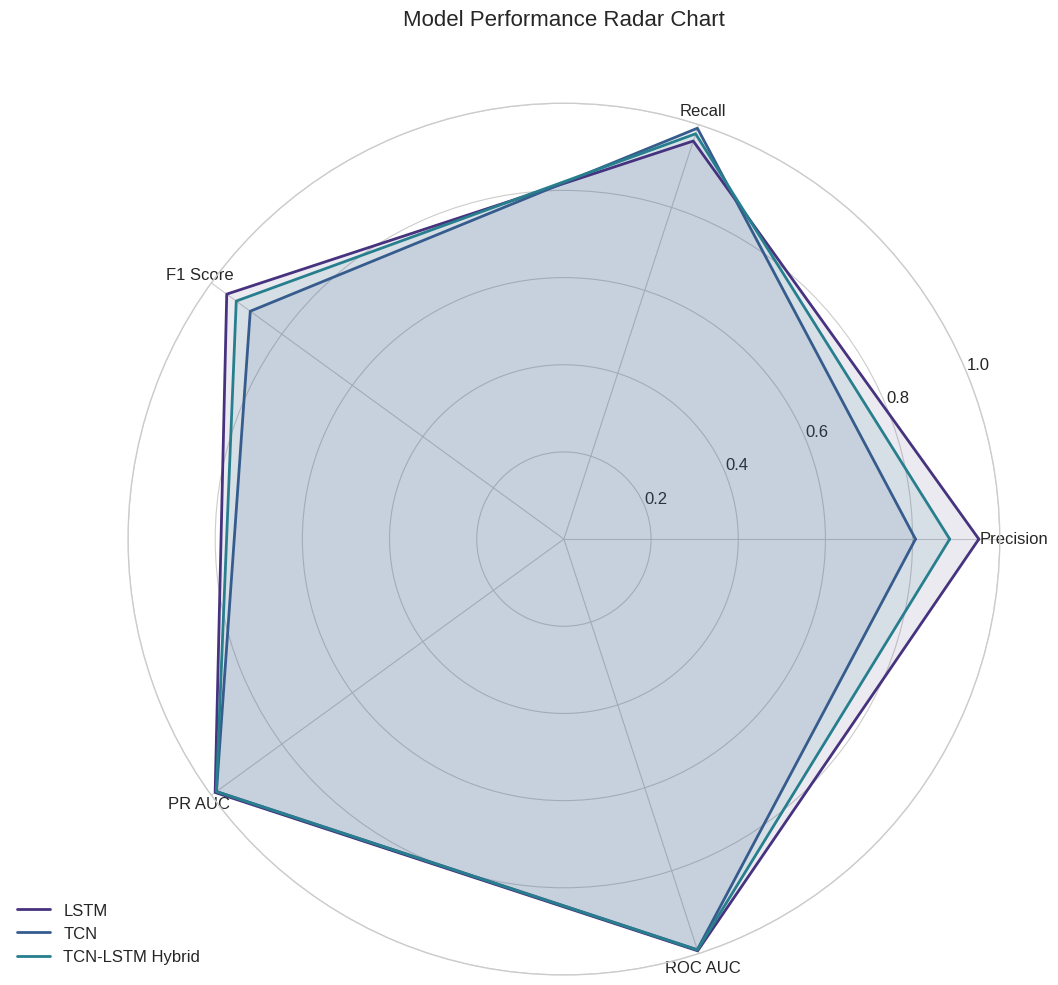


Analysis complete!


In [11]:
# Save models to Kaggle working directory
print("\nSaving models...")
lstm_model.save('/kaggle/working/lstm_model.keras')
tcn_model.save('/kaggle/working/tcn_model.keras')
hybrid_model.save('/kaggle/working/hybrid_model.keras')

# Plot comparative results across models
print("\nPlotting comparative results...")
plot_comparative_results(model_results)

print("\nAnalysis complete!")